# Setup

In [82]:
import os
import datetime
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Flatten, Softmax, Activation, SimpleRNN, Embedding, Conv2D
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import seaborn as sns
import pickle
from xgboost import XGBClassifier

#I may change environs between desktop & laptop, so I run the below to check my WD and that multicore processing is still available.
print("WD:", os.getcwd())
print("CPU cores:", os.cpu_count())

WD: C:\Users\rmcnei\Documents\CSC74020\Assignment2
CPU cores: 12



# Part A: Model Code and Exploration (100 pts)

1. Perform Exploratory Data Analysis (EDA) and discuss the data and what you observe
prior to beginning modeling and how impact how to proceed [10 pts]

In [2]:
full_train_data = pd.read_csv("8k_diabetes_train.csv",
                              na_values="?")
print("Length: ", len(full_train_data))
print("Width: ", len(full_train_data.columns))
print("Variables: ", full_train_data.columns)
full_train_data.head()

Length:  8000
Width:  40
Variables:  Index(['discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_diagnoses', 'max_glu_serum', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'insulin', 'glyburide.metformin',
       'glipizide.metformin', 'glimepiride.pioglitazone',
       'metformin.rosiglitazone', 'metformin.pioglitazone', 'change',
       'diabetesMed', 'readmitted', '2nd_diag', '3rd_diag', 'ai_response'],
      dtype='object')


,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_diagnoses,...,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,2nd_diag,3rd_diag,ai_response
0,Discharged to home,Transfer from a hospital,NaN,NaN,24,2,17,0,0,8,...,No,No,No,No,No,Yes,False,414,428,"Based on the diagnosis code 250.01, which indi..."
1,Discharged to home,Transfer from a hospital,NaN,NaN,37,3,14,0,0,8,...,No,No,No,No,No,Yes,False,410,414,"Based on the information provided, I recommend..."
2,Discharged to home,Emergency Room,SP,Emergency/Trauma,60,4,17,0,0,9,...,No,No,No,No,No,No,True,537,786,"Based on the information provided, the patient..."
3,Discharged to home,Emergency Room,NaN,NaN,40,3,25,1,0,9,...,No,No,No,No,Ch,Yes,True,425,428,"Based on the information provided, the patient..."
4,Discharged to home,Physician Referral,MD,Surgery-General,31,2,18,0,0,7,...,No,No,No,No,No,Yes,True,682,998,"Based on the information provided, the patient..."


In [3]:
# I investigated value counts for every variable. For brevity, I include only this one example in my final submission.
full_train_data.discharge_disposition_id.value_counts(dropna=False)

discharge_disposition_id
Discharged to home                                                                                             4864
Discharged/transferred to SNF                                                                                   954
Discharged/transferred to home with home health service                                                         920
NaN                                                                                                             364
Expired                                                                                                         153
Discharged/transferred to another short term hospital                                                           139
Discharged/transferred to another rehab fac including rehab units of a hospital.                                134
Discharged/transferred to another  type of inpatient care institution                                           130
Not Mapped                                     

In [4]:
full_train_data.payer_code.value_counts()

payer_code
MC    1988
HM     364
BC     300
SP     242
UN     221
MD     189
CP     159
CM      88
DM      46
OG      39
PO      34
WC       9
SI       8
OT       6
CH       5
Name: count, dtype: int64

For "Payer Code" & "Medical Specialty", "?" is the largest class. I re-wrote my read_csv command to explicitly identify these as NAs. This is a lot of missing data for these columns. Next, I'll look at the distributions of the continuous variables.

In [5]:
# I also did the below for all other continuous variables. Those cells have been deleted from the final submission for brevity.
full_train_data.num_lab_procedures.describe()

count    8000.000000
mean       43.183375
std        19.518187
min         1.000000
25%        32.000000
50%        44.000000
75%        57.000000
max       120.000000
Name: num_lab_procedures, dtype: float64

In [6]:
# I use the below code to identify which columns have any NAs.
pd.isna(full_train_data).max()

discharge_disposition_id     True
admission_source_id          True
payer_code                   True
medical_specialty            True
num_lab_procedures          False
num_procedures              False
num_medications             False
number_outpatient           False
number_emergency            False
number_diagnoses            False
max_glu_serum                True
metformin                   False
repaglinide                 False
nateglinide                 False
chlorpropamide              False
glimepiride                 False
acetohexamide               False
glipizide                   False
glyburide                   False
tolbutamide                 False
pioglitazone                False
rosiglitazone               False
acarbose                    False
miglitol                    False
troglitazone                False
tolazamide                  False
examide                     False
citoglipton                 False
insulin                     False
glyburide.metf

We have 8000 records of 39 features plus one target feature for readmission. We have a variety of continuous, categorical, and boolean variables, plus one string variable of text called "ai_response." For most of the continuous variables (and several of the others), there appear to be a small but not insignificant number of extreme outliers, I will want to keep this in mind when performing test_train_split and training.

Further, we have na values that we will want to somehow deal with in the variables: # Discharge_disposition_id, Admission_source_id, and Max_glu_serum, "Payer Code" & "Medical Specialty". I may also want to rename "?" values to proper NAs before doing so.

"2nd_diag" and "3rd_diag" are unclear. The name, repeated values, occasional letters & decimals all seem to imply diagnosis codes. As such, it may not be reasonable to try to impute the few NAs.

2. Pre-processed categorical data for use in the model and justified pre-processing
method. Note this may be different for each algorithm you try. [10 pts]

For simplicity, I might typically construct a class or pipeline that would perform pre-processing as part of the final model. However, to satisfy the structure of this assignment, I will instead perform pre-processing in discrete steps below (which will need to be repeated on the validation set later).

I address the columns in order, one at a time. First,  "discharge_disposition_id".

I believe this variable is best left as categorical (rather than ordinal), as there is no clear hierarchy of values. I believe "Not Mapped" should be NAs, and I reason that patients who die in care necessarily can't be readmitted, so other data about them may not be useful for predicting readmission. On inspection, I see no reasonable way to impute NAs as any other values.--The AI output seems to agree for many of those patients.

In [7]:
full_train_data.discharge_disposition_id = full_train_data.discharge_disposition_id.replace("Not Mapped", np.nan)

In [8]:
# I confirm no zombies in our data:
full_train_data.loc[(full_train_data['discharge_disposition_id'] == "Expired")].readmitted.value_counts()

readmitted
False    153
Name: count, dtype: int64

In [9]:
# I use the following method for dropping rows because alternative methods can result in missing indices.
# This method ensures that I will not encounter missing indices errors later on.
indices_to_drop = full_train_data[full_train_data['discharge_disposition_id'] == "Expired"].index
full_train_data.drop(index=indices_to_drop, inplace=True)
#See how the indices are not decremented
print("Index '135' is now labeled: ", (full_train_data.iloc[135].name))
# Check that rows have been successfully dropped.
print("Undropped rows: ", len(full_train_data.loc[(full_train_data['discharge_disposition_id'] == "Expired")].readmitted.value_counts()))

Index '135' is now labeled:  136
Undropped rows:  0


In [10]:
# I correct the index
full_train_data.set_index(np.arange(len(full_train_data)), inplace=True)
print("Index '135' is now labeled: ", (full_train_data.iloc[135].name))

Index '135' is now labeled:  135


Next, admission_source_id. I replace "Not Mapped" with NA.
Additionally, I do not believe it is possible to impute NAs. The distribution is relatively split across the two most prevalent categories, and there is no way to convert to numeric values.

In [11]:
full_train_data.admission_source_id = full_train_data.admission_source_id.replace("Not Mapped", np.nan)

Next, payer_code. "?" have already been read as NAs by my read_csv command.

My intuition for imputing NAs is that "?" for payer_code may imply patients who either do not have a way to pay right away, or who cannot pay at all. This may correlate with socioeconomic status, an external variable that may influence readmission. However, I cannot confirm this, and it may be a risk to impute NAs (or designate them their own category) when they represent the bulk of the data. I *try* imputing NAs as their own category, but I may change this later and compare the effect on model performance.

In [12]:
full_train_data.payer_code = full_train_data.payer_code.fillna("No_code")
full_train_data.payer_code.value_counts(dropna=False)

payer_code
No_code    4229
MC         1933
HM          360
BC          296
SP          239
UN          218
MD          186
CP          155
CM           86
DM           45
OG           38
PO           34
WC            9
SI            8
OT            6
CH            5
Name: count, dtype: int64

Next, medical_specialty. I replace obvious NAs. I also do not believe it is possible to simply impute NAs, as the data is categorical and NAs represent a sizable chunk of the data.

Given more time, it might be possible to do so using information from the "ai_response" column.

I do not change any other outliers or 'suspicious' values, as I am unsure if or how they should be recategorized. e.g. "Surgery-PlasticwithinHeadandNeck".

In [13]:
# Replacing obvious NA values
full_train_data.medical_specialty = full_train_data.medical_specialty.replace("PhysicianNotFound", np.nan)

Additionally, I prep medical_specialty for one-hot encoding by setting all but the 10 most common categories to NA. These also happen to be the only categories which each account for more than 1% of the data.

In [14]:
cols_to_keep = ("InternalMedicine", "Family/GeneralPractice", "Cardiology","Emergency/Trauma", "Surgery-General", "Orthopedics-Reconstructive", "Nephrology", "Psychiatry", "Orthopedics", "ObstetricsandGynecology")

full_train_data.loc[~full_train_data["medical_specialty"].isin(cols_to_keep), "medical_specialty"] = np.nan

In [15]:
full_train_data.medical_specialty.value_counts(dropna=False)

medical_specialty
NaN                           3927
InternalMedicine              1494
Family/GeneralPractice         675
Cardiology                     552
Emergency/Trauma               387
Surgery-General                269
Orthopedics-Reconstructive     132
Nephrology                     123
Psychiatry                     104
Orthopedics                    101
ObstetricsandGynecology         83
Name: count, dtype: int64

Next, max_glu_serum. I would consider this ordinal data, but not interval data, as I cannot confirm that the distance between "Norm" and ">200" is equal to the distance between ">200" and ">300". So I will One-Hot encode this variable at the end of this section, instead of label encoding.
Assuming these are readings for blood glucose serum test, I'm assuming it is only administered when there is a reasonable chance that the patient's blood glucose might be abnormal. As such, it may be reasonable to impute NAs as "Norm". However, I wound up making NAs their own category, since information may be gleaned from the fact that a doctor thought administration of a test was necessary at all, even if blood glucose came back normal.

In [16]:
full_train_data.max_glu_serum = full_train_data.max_glu_serum.fillna("No_test")
full_train_data.max_glu_serum.value_counts(dropna=False)

max_glu_serum
No_test    7333
Norm        267
>200        152
>300         95
Name: count, dtype: int64

Next, "Metformin" through "Insulin" appear to be ordinal, but not interval, same problem as above. I will one-hot encode these later. I drop acetohexamide, troglitazone, examide, and citoglipton because they contain only one value.

In [17]:
for col in full_train_data.columns[11:28]:
    print(col,":", len(full_train_data[col].unique()))

metformin : 4
repaglinide : 4
nateglinide : 4
chlorpropamide : 3
glimepiride : 4
acetohexamide : 1
glipizide : 4
glyburide : 4
tolbutamide : 2
pioglitazone : 4
rosiglitazone : 4
acarbose : 3
miglitol : 4
troglitazone : 1
tolazamide : 2
examide : 1
citoglipton : 1


In [18]:
full_train_data = full_train_data.drop(["acetohexamide",
                                        "troglitazone",
                                        "examide",
                                        "citoglipton"],
                                       axis=1)

Next, I drop nateglinide, chlorpropamide, tolbutamide, acarbose, miglitol, and tolazamide, because the "No" class represents 99% or more of records. 99% is an arbitrary threshold; realistically, I could probably drop even more of these columns.

In [19]:
for col in full_train_data.columns[11:24]:
    print(full_train_data[col].value_counts(),"\n")

metformin
No        6279
Steady    1435
Up          95
Down        38
Name: count, dtype: int64 

repaglinide
No        7741
Steady      91
Up          11
Down         4
Name: count, dtype: int64 

nateglinide
No        7804
Steady      41
Down         1
Up           1
Name: count, dtype: int64 

chlorpropamide
No        7836
Steady      10
Up           1
Name: count, dtype: int64 

glimepiride
No        7457
Steady     356
Up          26
Down         8
Name: count, dtype: int64 

glipizide
No        6800
Steady     934
Up          74
Down        39
Name: count, dtype: int64 

glyburide
No        6920
Steady     799
Up          80
Down        48
Name: count, dtype: int64 

tolbutamide
No        7846
Steady       1
Name: count, dtype: int64 

pioglitazone
No        7295
Steady     525
Up          20
Down         7
Name: count, dtype: int64 

rosiglitazone
No        7247
Steady     576
Up          17
Down         7
Name: count, dtype: int64 

acarbose
No        7822
Steady      24
Up    

In [20]:
full_train_data = full_train_data.drop(["nateglinide",
                                        "chlorpropamide",
                                        "tolbutamide",
                                        "acarbose",
                                        "miglitol",
                                        "tolazamide"],
                                       axis=1)

Next, I drop "glyburide.metformin" and "glipizide.metformin" because nearly all values are "no", and I drop "glimepiride.pioglitazone" through "metformin.pioglitazone" because they *only* contain "no" values.


In [21]:
#Print number of unique values
for col in full_train_data.columns[19:24]:
    print(col,":", len(full_train_data[col].unique()))

glyburide.metformin : 4
glipizide.metformin : 2
glimepiride.pioglitazone : 1
metformin.rosiglitazone : 1
metformin.pioglitazone : 1


In [22]:
full_train_data.value_counts("glyburide.metformin")
# 99.43% of the data is "no".

glyburide.metformin
No        7803
Steady      42
Down         1
Up           1
Name: count, dtype: int64

In [23]:
full_train_data.value_counts("glipizide.metformin")

glipizide.metformin
No        7845
Steady       2
Name: count, dtype: int64

In [24]:
full_train_data = full_train_data.drop(["glyburide.metformin",
                                        "glipizide.metformin",
                                        "glimepiride.pioglitazone",
                                        "metformin.rosiglitazone",
                                        "metformin.pioglitazone"],
                                       axis=1)

"change", "diabetes_med" and "readmitted" I encode as a binary. This is both to ensure it reads as a 0-1 or true-false to my model(s), and for interpretability. I also encode 'change' and 'diabetesMed" as objects to simply include them in the categorical set for OneHotEncoding later.

"readmitted" I pull out here to make my target vector

In [25]:
full_train_data.change = full_train_data.change.replace("Ch", 1)
full_train_data.change = full_train_data.change.replace("No", 0)
full_train_data.change = full_train_data.change.astype("object")


full_train_data.diabetesMed = full_train_data.diabetesMed.replace("Yes", 1)
full_train_data.diabetesMed = full_train_data.diabetesMed.replace("No", 0)
full_train_data.diabetesMed = full_train_data.diabetesMed.astype("object")

full_train_data.readmitted = full_train_data.readmitted.replace(True, 1)
full_train_data.readmitted = full_train_data.readmitted.replace(False, 0)
full_train_data_targetVector = np.array(full_train_data.readmitted)

C:\Users\rmcnei\AppData\Local\Temp\ipykernel_28488\2301618933.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_train_data.change = full_train_data.change.replace("No", 0)
C:\Users\rmcnei\AppData\Local\Temp\ipykernel_28488\2301618933.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_train_data.diabetesMed = full_train_data.diabetesMed.replace("No", 0)
C:\Users\rmcnei\AppData\Local\Temp\ipykernel_28488\2301618933.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future vers

In [26]:
full_train_data_targetVector

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

"2nd_diag" and "3rd_diag". As stated above, I believe these may be diagnosis codes. This may be important information for predicting readmission. I can't impute NAs and I consider them as categorical. Below I ensure these columns are set as strings, rather than floats. There is no way to reasonably one-hot encode without either a) massively expanding the dimensionality of our data by 390 columns (nunique values) or b) cutting several categories which still contain many patients.  

In [27]:
full_train_data["2nd_diag"] = full_train_data["2nd_diag"].astype(str)
full_train_data["3rd_diag"] = full_train_data["3rd_diag"].astype(str)

In [28]:
# It is not possible for a column to have more than one datatype. I re-confirm that my index has been set correctly and that no glitches have occurred in type processing (by the absense of errors) in the below.
for j in ("2nd_diag", "3rd_diag"):
    for i in np.arange(len(full_train_data)):
        if type(full_train_data[j][i]) != str:
            print(j,i,type(full_train_data[j][i]))

In [29]:
# I set these aside as their own set, I may use them in their own model, or encode them with a different method than that used for the remainder of the categorical data.
diags_full_train_data = full_train_data[["2nd_diag", "3rd_diag"]]

In [30]:
diags_full_train_data

,2nd_diag,3rd_diag
0,414,428
1,410,414
2,537,786
3,425,428
4,682,998
...,...,...
7842,276,584
7843,309,496
7844,428,786
7845,401,493


My biggest lingering concern is how to encode these categorical variables. On one hand, multi-label encoding could cause my models to misinterpret categorical data as having an ordered, ratio relationship; on the other, one-hot encoding would explode the number of columns given the number of categories and categorical variables I have, possibly leading to high-dimensionality problems.

In [31]:
Cat_full_train_data = full_train_data[full_train_data.dtypes[full_train_data.dtypes == "object"].index[0:15]].copy()

total_cols = 0

for col in Cat_full_train_data.columns:
    total_cols += Cat_full_train_data[col].nunique()
    print(col,":", len(Cat_full_train_data[col].unique()))
print("Intended OneHot cats: ", total_cols - 2)

discharge_disposition_id : 18
admission_source_id : 10
payer_code : 16
medical_specialty : 11
max_glu_serum : 4
metformin : 4
repaglinide : 4
glimepiride : 4
glipizide : 4
glyburide : 4
pioglitazone : 4
rosiglitazone : 4
insulin : 4
change : 2
diabetesMed : 2
Intended OneHot cats:  90


OneHotEncoder seems to have no simple method for handling NANs and plans to implement such a feature have not been followed up since 2020:
https://github.com/scikit-learn/scikit-learn/issues/11996
So, I will have to manually drop these columns from the sparse matrix.

In [32]:
ohe = skl.preprocessing.OneHotEncoder(drop='if_binary', 
                                      handle_unknown="ignore",
                                      sparse_output=False)
ohe.fit(Cat_full_train_data)
encCat_full_train_data = ohe.transform(Cat_full_train_data)
ohe.get_feature_names_out()

array(['discharge_disposition_id_Admitted as an inpatient to this hospital',
       'discharge_disposition_id_Discharged to home',
       'discharge_disposition_id_Discharged/transferred to ICF',
       'discharge_disposition_id_Discharged/transferred to SNF',
       'discharge_disposition_id_Discharged/transferred to a long term care hospital.',
       'discharge_disposition_id_Discharged/transferred to another  type of inpatient care institution',
       'discharge_disposition_id_Discharged/transferred to another rehab fac including rehab units of a hospital.',
       'discharge_disposition_id_Discharged/transferred to another short term hospital',
       'discharge_disposition_id_Discharged/transferred to home under care of Home IV provider',
       'discharge_disposition_id_Discharged/transferred to home with home health service',
       'discharge_disposition_id_Discharged/transferred within this institution to Medicare approved swing bed',
       'discharge_disposition_id_Dischar

In [33]:
cols_to_drop = set((17,27,54))
cols_to_keep = list(set(range(encCat_full_train_data.shape[1]))-cols_to_drop)
encCat_full_train_data = encCat_full_train_data[:, cols_to_keep]
print("OneHotCats: ", encCat_full_train_data.shape[1])

OneHotCats:  90


3. Pre-processed numerical data appropriately including handling missing data and
justified methods used. Note this may be different for each algorithm you try. [10 pts]

We already confirmed above that there are no NAs in our continuous data, so no need to impute.

I choose to scale the numeric columns since all the model types I will implement work better with (or require) scaled data. I will also test each of my models with the unscaled numeric data and compare performance.

In [34]:
scaler = skl.preprocessing.StandardScaler()
#Create new df for scaled numeric data
num_full_train_data = full_train_data[full_train_data.dtypes[full_train_data.dtypes == "int64"].index[0:6]].copy()

scaledNum_full_train_data = scaler.fit_transform(num_full_train_data)

While I'm at it, I also create a pairplot of my scaled numeric features for further EDA.

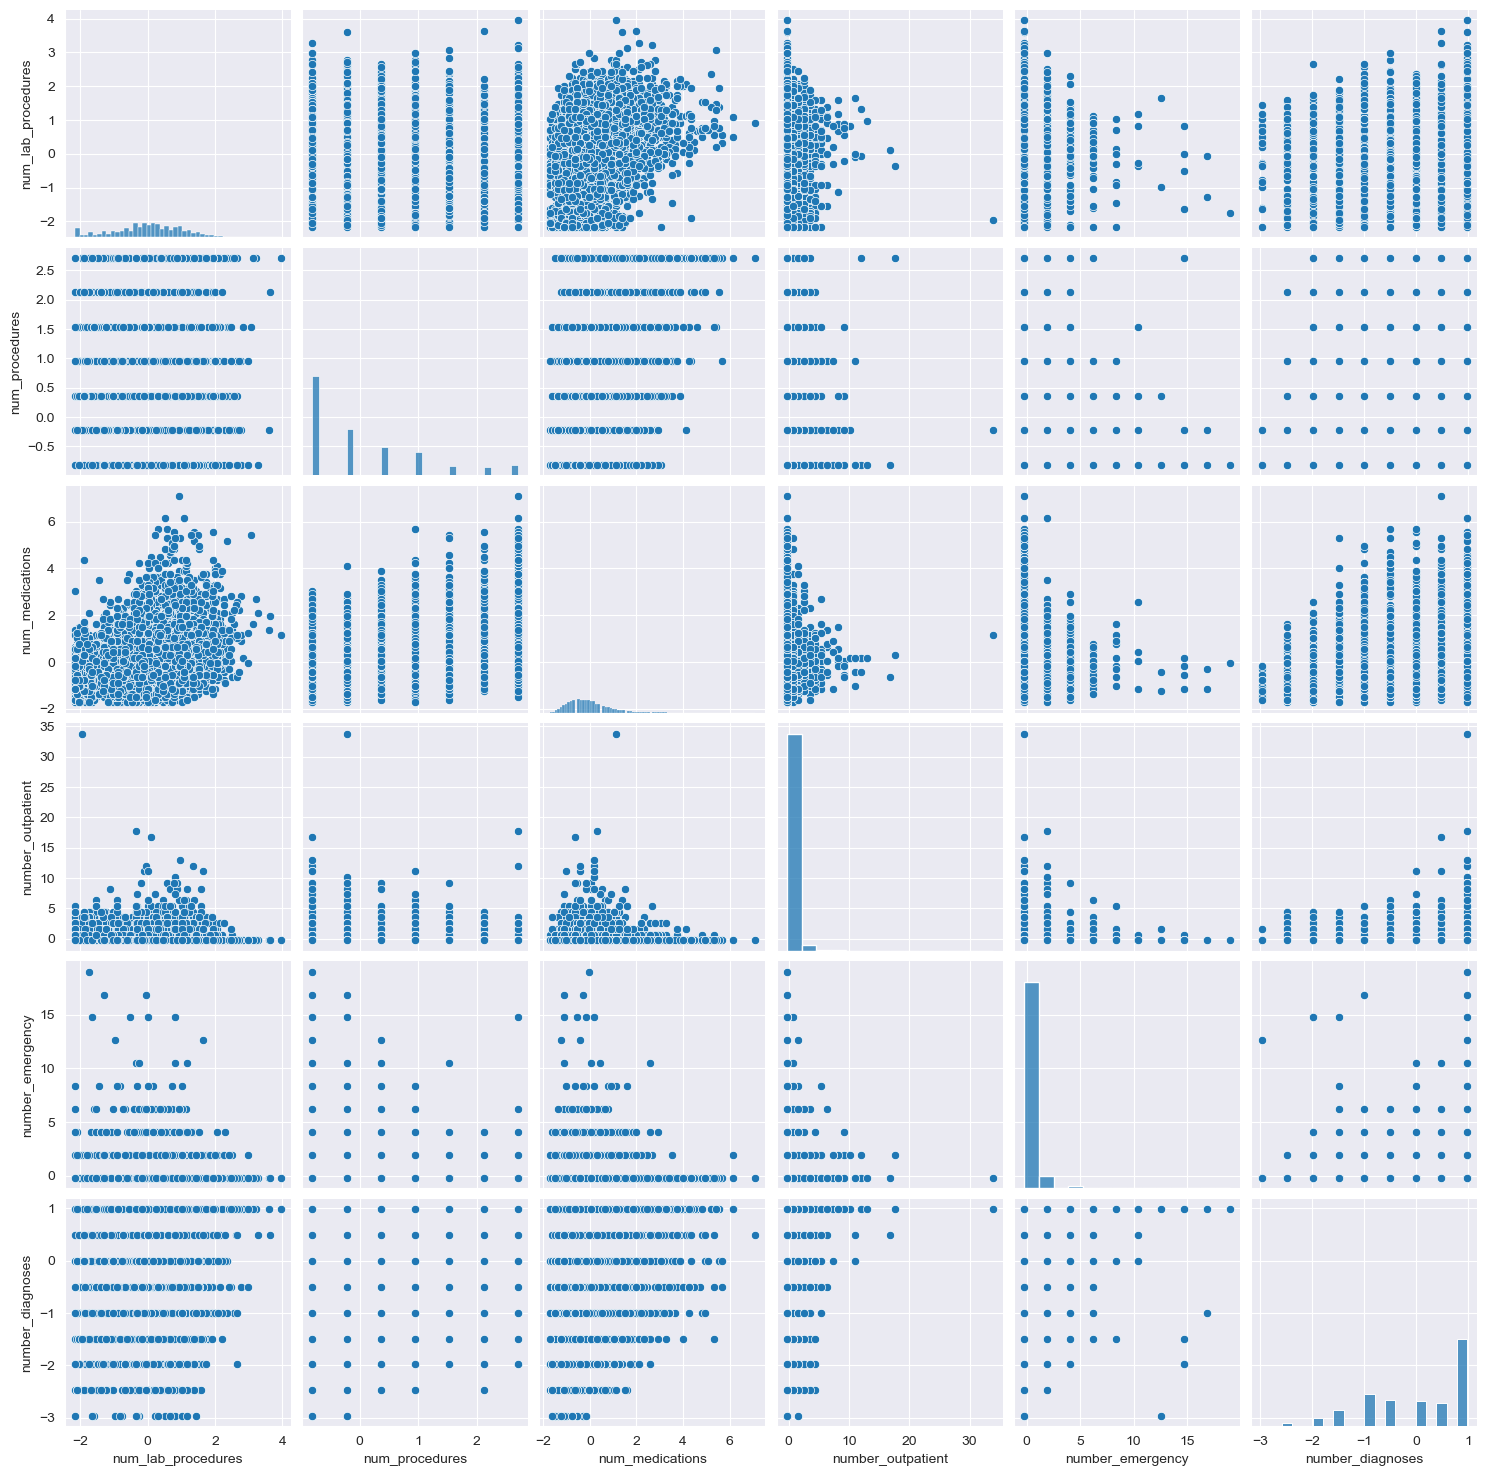

In [35]:
# I use a for loop to quickly transform all numeric columns in a format acceptable to seaborn.
scaler2 = skl.preprocessing.StandardScaler()

numeric_columns = list(full_train_data.dtypes[full_train_data.dtypes == "int64"].index)[0:6]

scaledNum_full_train_data2 = full_train_data[full_train_data.dtypes[full_train_data.dtypes == "int64"].index[0:6]].copy()

for column in numeric_columns:
    transformed_column = scaler2.fit_transform(np.array(full_train_data[column]).reshape(-1,1))
    scaledNum_full_train_data2[column] = transformed_column

sns.pairplot(scaledNum_full_train_data2)

4. Implement a model to make predictions using text data using tf-idf [20 pts]

I start by vectorizing the ai_response data

In [36]:
vectorizer = skl.feature_extraction.text.TfidfVectorizer(strip_accents = 'unicode',
                                                         norm = "l1")
textVect_full_train_data = vectorizer.fit_transform(full_train_data["ai_response"])
vectorizer.get_feature_names_out()

array(['01', '02', '03', ..., 'you', 'young', 'younger'], dtype=object)

I implement a test/train split.

In [37]:
text_X_train, text_X_test, text_y_train, text_y_test = train_test_split(
    textVect_full_train_data.toarray(), 
    full_train_data_targetVector,
    stratify=full_train_data_targetVector,
    test_size=0.2,
    random_state=42)

I attempt classification with SVM. I choose SVMs because of their usefulness with high-dimensionality data. I also tested some RF & KNN models, but both models performed worse than SVMs. That code has been omitted from here for readability. Below is a gridsearch, the parameter lists of which are themselves the result of extensive parameter optimization.

In [38]:
# start = datetime.datetime.now()
# parameters = {'C': [0.01, 0.1, 0.2, 0.3, 1, 10],
#               'degree': [1, 2, 3, 4],
#               'gamma': ['scale', 0.1, 1, 5, 7, 8, 9, 10],
#               'class_weight': [{1: 0.9}, None, {1: 1.1}, 'balanced']}
# sv_clf = skl.svm.SVC(kernel = "poly")
# gs_sv_clf = skl.model_selection.GridSearchCV(sv_clf,
#                                              parameters,
#                                              scoring="roc_auc",
#                                              n_jobs=-1
#                                              )
# 
# gs_sv_clf.fit(text_X_train, text_y_train)
# 
# end = datetime.datetime.now()
# time_elapsed = end - start
# print("Time elapsed: ", time_elapsed)
# 
# gs_sv_clf.best_estimator_

In [39]:
sv_clf = skl.svm.SVC(C = 0.2,
                     kernel="poly",
                     degree = 3,
                     gamma = 10,
                     class_weight = None
                     )
sv_clf.fit(text_X_train, text_y_train)
svc_preds = sv_clf.predict(text_X_test)
print("Model accuracy: ", skl.metrics.accuracy_score(text_y_test, svc_preds)) 
print("Model F1: ", skl.metrics.f1_score(text_y_test, svc_preds))
print("Model AUC: ", skl.metrics.roc_auc_score(text_y_test, svc_preds)) #0.5673827

Model accuracy:  0.5910828025477707
Model F1:  0.0
Model AUC:  0.5


SVC achieves very limited performance. Next I try a simple NN model. It achieves even poorer performance.

In [40]:
nn = Sequential()
nn.add(Flatten())
nn.add(Dense(1000, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

nn.fit(text_X_train, text_y_train)
nn_probs=nn.predict(text_X_test)
nn_preds=tf.greater(nn_probs, 0.5)

print("NN Accuracy: ", skl.metrics.accuracy_score(text_y_test, nn_preds))
print("NN F1: ", skl.metrics.f1_score(text_y_test, nn_preds))
print("NN AUC: ", skl.metrics.roc_auc_score(text_y_test, nn_preds))

197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - AUC: 0.5000 - loss: 0.6779
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
NN Accuracy:  0.5910828025477707
NN F1:  0.0
NN AUC:  0.5


For comparision, a simple untuned Naive Bayes achieves only somewhat worse performance than either of the models above.

In [41]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(text_X_train, text_y_train)

#predicted y
NB_pred = naive_bayes_classifier.predict(text_X_test)
print("Naive Bayes Accuracy: ", skl.metrics.accuracy_score(text_y_test, NB_pred))
print("Naive Bayes F1: ", skl.metrics.f1_score(text_y_test, NB_pred))
print("Naive Bayes AUC: ", skl.metrics.roc_auc_score(text_y_test, NB_pred))

Naive Bayes Accuracy:  0.5910828025477707
Naive Bayes F1:  0.0
Naive Bayes AUC:  0.5


None of these models can achieve particularly good performance. None can achieve an accuracy greater than about 59% (and with very low F1 scores). Even our optimized SVM model can only achieve an AUC of 0.57. I select my optimized SVC as my final text classification model for stacking.

5. Use model stacking to incorporate tf-idf predictions for the text field
("ai_response") in the downstream algorithm [20 pts]

Below I construct a custom model stacking model. It will be applied as part of implementation of my final model.

In [42]:
class custom_stacking_classifier:
    """
    Custom stacking classifier for this dataset.
    
    Parameters
    __________
    categorical_classifier : fitted model object
            Trained classifier model for categorical data
    categorical_transformer : fitted OneHotEncoder object
            Fitted encoder for categorical data
    numeric_classifier : fitted model object
            Trained classifier model for numeric data
    numeric_transformer: fitted StandardScalar object
            Fitted StandardScaler for numeric data
    text_classifier : fitted model object
            Trained classifier for text data
    text_transformer : fitted TfidfVectorizer object
            Fitted TfidfVectorizer for text data
    final_classifier : fitted model object
            Classifier for combined models' predictions (default is Logistic Regression).
    """
    def __init__(self, categorical_classifier = None, categorical_transformer = None, numeric_classifier = None, numeric_transformer = None, text_classifier = None, text_transformer = None, final_classifier = skl.linear_model.LogisticRegression()):
        self._categorical_classifier = categorical_classifier
        self._categorical_transformer = categorical_transformer
        self._numeric_classifier = numeric_classifier
        self._numeric_transformer = numeric_transformer
        self._text_classifier = text_classifier
        self._text_transformer = text_transformer
        self._final_classifier = final_classifier
    
    def preprocess(self, train_X: pd.core.frame.DataFrame):
        """
        Preprocess the data.
        
        :train_X: diabetes data dataframe.
        :return: preprocessed dataframe.
        """
        transformed_data = train_X.copy()
        transformed_data.discharge_disposition_id = transformed_data.discharge_disposition_id.replace("Not Mapped", np.nan)
        transformed_data.drop(index=transformed_data[transformed_data['discharge_disposition_id'] == "Expired"].index, inplace=True)
        transformed_data.set_index(np.arange(len(transformed_data)), inplace=True)
        transformed_data.admission_source_id = transformed_data.admission_source_id.replace("Not Mapped", np.nan)
        transformed_data.payer_code = transformed_data.payer_code.fillna("No_code")
        transformed_data.medical_specialty = transformed_data.medical_specialty.replace("PhysicianNotFound", np.nan)
        transformed_data.loc[~transformed_data["medical_specialty"].isin(("InternalMedicine", "Family/GeneralPractice", "Cardiology","Emergency/Trauma", "Surgery-General", "Orthopedics-Reconstructive", "Nephrology", "Psychiatry", "Orthopedics", "ObstetricsandGynecology")), "medical_specialty"] = np.nan
        transformed_data.max_glu_serum = transformed_data.max_glu_serum.fillna("No_test")
        transformed_data = transformed_data.drop(["acetohexamide",
                                        "troglitazone",
                                        "examide",
                                        "citoglipton",
                                        "nateglinide",
                                        "chlorpropamide",
                                        "tolbutamide",
                                        "acarbose",
                                        "miglitol",
                                        "tolazamide",
                                        "glyburide.metformin",
                                        "glipizide.metformin",
                                        "glimepiride.pioglitazone",
                                        "metformin.rosiglitazone",
                                        "metformin.pioglitazone",
                                        "2nd_diag",
                                        "3rd_diag"],
                                       axis=1)

        transformed_data.change = transformed_data.change.replace("No", 0)
        transformed_data.change = transformed_data.change.replace("Ch", 1)
        transformed_data.change = transformed_data.change.astype("object")
        transformed_data.diabetesMed = transformed_data.diabetesMed.replace("Yes", 1)
        transformed_data.diabetesMed = transformed_data.diabetesMed.replace("No", 0)
        transformed_data.diabetesMed = transformed_data.diabetesMed.astype("object")
        
        _encCat_full_train_data = self._categorical_classifier.transform(transformed_data[transformed_data.dtypes[transformed_data.dtypes == "object"].index[0:15]])
        _encCat_full_train_data = _encCat_full_train_data[:, list(set(range(_encCat_full_train_data.shape[1]))-set((17,27,54)))]
        self._encCat_full_train_data = _encCat_full_train_data
        
        _scaledNum_full_train_data = self._numeric_transformer.transform(transformed_data[transformed_data.dtypes[transformed_data.dtypes == "int64"].index[0:6]])
        self._scaledNum_full_train_data = _scaledNum_full_train_data
        
        _textVect_full_train_data = self._text_transformer.transform(transformed_data["ai_response"])
        self._textVect_full_train_data = _textVect_full_train_data
        return self._encCat_full_train_data, self._scaledNum_full_train_data, self._textVect_full_train_data

def fit(self, X_train, X_test, y_train, y_test):
        _model_classifications = np.empty((0,3))
        categorical_classifications = self.categorical_classifier.predict(X_train, y_train)
        numeric_classifications = self.numeric_classifier.predict(X_train, y_train)
        text_classifications = self.text_classifier.predict(X_train, y_train)
        


In [43]:
np.empty((0,3))


array([], shape=(0, 3), dtype=float64)

6. Perform experimentation for multiple modeling algorithms and justify why you
selected the experiments you chose [20 pts]

First, I design & optimize a model for **categorical data** classification.

Test/train split

In [50]:
cat_X_train, cat_X_test, cat_y_train, cat_y_test = train_test_split(
    encCat_full_train_data,
    full_train_data_targetVector,
    stratify=full_train_data_targetVector,
    test_size=0.2,
    random_state=42)

LogReg Model

In [ ]:
start = datetime.datetime.now()
parameters = {'penalty': ['l1', 'l2', 'elasticnet'],
              'tol': [1e-5, 1e-4, 1e-3],
              'C': [0.1, 0.9, 1, 1.1, 10, 100, 1000],
              'class_weight': ['balanced', {1:0.9}, None, {1:1.1}],
              'solver': ['linear', 'liblinear', 'saga']}

lrc = skl.linear_model.LogisticRegression(max_iter = 100000,
                                          random_state = 42)

gs_lrc = skl.model_selection.GridSearchCV(lrc,
                                          parameters,
                                          scoring="roc_auc",
                                          n_jobs=-1
                                          )

gs_lrc.fit(cat_X_train, cat_y_train)

end = datetime.datetime.now()
time_elapsed = end - start
print("Time elapsed: ", time_elapsed)
gs_lrc.best_estimator_

In [ ]:
lrc = skl.linear_model.LogisticRegression(max_iter = 1000,
                                          random_state = 42)
lrc.fit(cat_X_train, cat_y_train)
lrc_preds = lrc.predict(cat_X_test)
print("LRM Accuracy: ", skl.metrics.accuracy_score(lrc_preds, cat_y_test))
print("LRM F1: ", skl.metrics.f1_score(lrc_preds, cat_y_test))
print("LRM AUC: ", skl.metrics.roc_auc_score(lrc_preds, cat_y_test))

RF Model

In [ ]:
start = datetime.datetime.now()
parameters = {'n_estimators': [100, 500, 1000],
              'criterion': []}

rfc = skl.ensemble.RandomForest(random_state = 42)

gs_rfc = skl.model_selection.GridSearchCV(rfc,
                                          parameters,
                                          scoring="roc_auc",
                                          n_jobs=-1
                                          )

gs_rfc.fit(cat_X_train, cat_y_train)

end = datetime.datetime.now()
time_elapsed = end - start
print("Time elapsed: ", time_elapsed)

gs_rfc.best_estimator_

In [61]:
rfc = skl.ensemble.RandomForestClassifier(n_estimators =1000,
                                          random_state = 42)
rfc.fit(cat_X_train, cat_y_train)
rfc_preds = rfc.predict(cat_X_test)
print("LRM Accuracy: ", skl.metrics.accuracy_score(rfc_preds, cat_y_test))
print("LRM F1: ", skl.metrics.f1_score(rfc_preds, cat_y_test))
print("LRM AUC: ", skl.metrics.roc_auc_score(rfc_preds, cat_y_test))

LRM Accuracy:  0.5923566878980892
LRM F1:  0.46037099494097805
LRM AUC:  0.5710945562435501


XGBoost Model

Second, I design & optimize a model for **numeric data** classification

In [45]:
##### Now we have 4 datasets & sub-models: #####
# Categorical encoded: encCat_full_train_data
# transformer: ohe
# model: 

# diag_codes: diag_full_train_data
# transformer: OMITTED
# model: OMITTED

# Numeric scaled: scaledNum_full_train_data
# transformer: scaler
# model: 

# text data: 
# data: textVect_full_train_data
# transformer: vectorizer
# model: sv_clf

# target vector: 
# full_train_data_targetVector

7. Final model selection and discussion of your model choice and the model weaknesses
(generally, where model doesn’t perform well, etc.) [10 pts]

# Part B: Model Performance (100 pts)

Achieve AUC >= .675

In [46]:
unprocessed_data = pd.read_csv("2k_diabetes_test_no_label.csv",
                               na_values="?")

csc = custom_stacking_classifier(categorical_classifier = ohe, categorical_transformer = None, numeric_classifier = None, numeric_transformer = scaler, text_classifier = None, text_transformer = vectorizer, final_classifier = skl.linear_model.LogisticRegression())

encCat_validation, scaledNum_validation, textVect_validation = csc.preprocess(data = unprocessed_data)


TypeError: custom_stacking_classifier.preprocess() got an unexpected keyword argument 'data'